In [26]:
!pip install --upgrade pip
!pip install --upgrade pypdf langchain-text-splitters langchain-community langgraph langchain-openai python-dotenv rapidocr-onnxruntime langsmith tiktoken langchainhub langchain
!pip install -qU "langchain[openai]"

In [27]:
import os
import pprint
from dotenv import load_dotenv
from pypdf import PdfReader
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from IPython.display import Image, display

In [28]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING", "false")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY", "not provided")

In [29]:
!pip install chromadb

In [30]:
# Indexing
def load_pdfs_recursively(directory):
    all_pages = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(".pdf"):
                pdf_path = os.path.join(root, file)
                try:
                    with open(pdf_path, 'rb') as f:
                        PdfReader(f)  # will raise an exception if the PDF is invalid

                    loader = PyPDFLoader(pdf_path, extract_images=False)  # set to False unless you NEED images
                    pages = loader.load()
                    all_pages.extend(pages)
                except Exception as e:
                    print(f"Error processing {pdf_path}: {e}")
    return all_pages

pdf_directory = "pdfs"  # path to dir with PDFs
docs = load_pdfs_recursively(pdf_directory)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=50)
all_splits = text_splitter.split_documents(docs)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=all_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

print("Index created!")

Index created!


In [31]:
# Create a retriever tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_pdf_documents",
    "Search and return information about how to create academic resumes.",
)

tools = [retriever_tool]

In [32]:
# Agent State
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [33]:
### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [34]:
# Graph
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

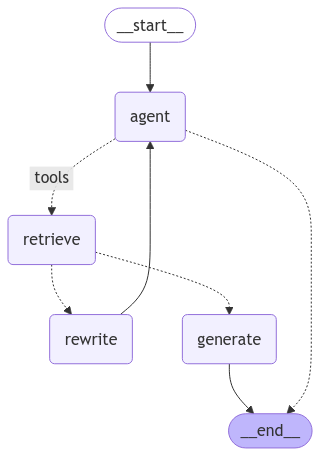

In [35]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
inputs = {
    "messages": [
        ("user", "What should I highlight in an academic resume?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='In an academic resume, you should highlight the following key elements:\n\n1. **Contact Information**: Include your full name, address, phone number, and email address.\n\n2. **Objective or Summary**: A brief statement about your career goals and what you hope to achieve in the academic field.\n\n3. **Education**: List your academic qualifications in reverse chronological order. Include the name of the institution, degree obtained, and dates attended. Mention any honors or distinctions.\n\n4. **Research Experience**: Detail your research projects, including your role, the scope of the project, methodologies used, and any significant findings or contributions.\n\n5. **Teaching Experience**: Include any teaching roles, such as teaching assistantships or lectureships. Mention the courses taught and any innovative teaching methods you employed.\n\n6. **Publications**: List your published works, including 

In [37]:
inputs = {
    "messages": [
        ("user", "Who is Sanjana Singh?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content="There are many individuals named Sanjana Singh, and without additional context, it's difficult to identify which specific person you are referring to. Sanjana Singh could be a common name and might refer to a professional in various fields such as academia, entertainment, business, or others. If you have more details or context about the person you are inquiring about, please provide them so I can assist you better.", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f'}, id='run-8090c4a6-f836-45af-b208-0bb604453e9d-0')]}
'\n---\n'
